
# **<center>Model for Predicting Credit Card Fraud** </center>
----------

**<br>2023F-T3 BDM 3035 - Big Data Capstone Project 01**
<br>Group 1:
<br>&emsp;&emsp;Jefford Secondes
<br>&emsp;&emsp;Jovi Fez Bartolata
<br>&emsp;&emsp;Luz Zapanta
<br>&emsp;&emsp;Maricris Resma
<br>&emsp;&emsp;Keyvan Amini

--------------------


**PROJECT DESCRIPTION:**

The major goal of the project is to develop a predictive modelling application that effectively predicts credit card fraudulent actions, such as identity theft, financial fraud, and unauthorized access. Various supervised machine learning classifier algorithms will be developed and tested upon to be able to identify the model that gives the best accuracy that satisfies the requirement of greater than 80% accuracy. Historical data will be evaluated using various machine learning models, identifying abnormalities and trends suggestive of fraudulent activities. The fraud detection application, aimed to protect the integrity of Bank of Mississauga's operations, shall be used to mitigate fraudulent transactions. This comprehensive approach addresses both known fraud trends and emergent threats, providing a proactive defense mechanism against developing fraud strategies.

**OBJECTIVES:**

● Retrieve and manage credit card transaction Data from Google Cloud Platform

● Create a machine learning classifier model capable of detecting credit card fraud using Logistic Regression Model, Decision Tree, or Random Forest.

● Improve the adaptability of the model to evolving fraud patterns through continuous learning.

● Reduce false positives to guarantee a seamless and trustworthy user experience.

● Deliver the pickle file that can be integrated into Bank of Mississauga’s organizational systems and databases to assure seamless operation


----------
## <center> GCP Connection
----------

In [ ]:
#For google cloud
# pip install --upgrade google-api-python-client
# pip install --upgrade google-cloud-storage
# https://cloud.google.com/storage/docs/reference/libraries?authuser=1#client-libraries-install-python
try:
    from google.cloud import storage
    import google.cloud.storage
    import json
    import os
    import sys
except Exception as e:
    print("Error : {} ".format(e))

In [ ]:
# We have a key that will connect as using .json file, you can have this key form jefford
PATH = os.path.join(os.getcwd() , 'creditfraud-beta-404714-e0536176176a.json')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = PATH

In [ ]:
storage_client = storage.Client(PATH)
storage_client

In [ ]:
bucket = storage_client.get_bucket('ccfraudbucket')

In [ ]:
filename = [filename.name for filename in list(bucket.list_blobs(prefix='')) ]
filename

----------
## <center> Data Preprocessing
----------

In [8]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTENC
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

Read Data

In [ ]:
# RUN THIS IF YOU ARE GOING TO USE GCP

df_raw = pd.read_csv(
    io.BytesIO(
                 bucket.blob(blob_name = 'credit_card_transactions-ibm_v2.csv').download_as_string() 
              ) ,
                 encoding='UTF-8',
                 sep=',')

In [9]:
df_raw = pd.read_csv("./credit_card_transactions-ibm_v2.csv")
# df_raw = pd.read_csv(r"C:\Users\barto\Documents\Lambton\Term 3\2023F-T3 BDM 3035 - Big Data Capstone Project\Project\credit_card_transactions-ibm_v2.csv")

In [10]:
df_raw.head(2)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No


### Data Profiling

In [11]:
# Display dataframe information to get more details about the raw data.
df_raw.info()

# Overview of the summary statistics: mean, min, max, std
df_raw.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.150876e+07,2.438690e+07
mean,1.001019e+03,1.351366e+00,2.011955e+03,6.525064e+00,1.571812e+01,-4.769230e+17,5.095644e+04,5.561171e+03
std,5.694612e+02,1.407154e+00,5.105921e+00,3.472355e+00,8.794073e+00,4.758940e+18,2.939707e+04,8.793154e+02
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-9.222899e+18,5.010000e+02,1.711000e+03
25%,5.100000e+02,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.500543e+18,2.837400e+04,5.300000e+03
50%,1.006000e+03,1.000000e+00,2.013000e+03,7.000000e+00,1.600000e+01,-7.946765e+17,4.674200e+04,5.499000e+03
75%,1.477000e+03,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.189517e+18,7.756400e+04,5.812000e+03
max,1.999000e+03,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.223292e+18,9.992800e+04,9.402000e+03


**Observations:**
- The raw data has 24,386,900  observations/rows and 15 variables/columns.
- Y Variable / Dependent Variable is <b>Is Fraud?</b>
- X Variable / Independent Variables will be taken from the other 14 variables 


**Observation**
- Raw data class imbalance has 24,357,143 No and 29,757 Yes
- Majority of the transactions was not fraud. Only 0.122% of the transactions were fraud, therefore, we have an highly imbalanced class.


In [12]:
print('Summary by Year:')
print(df_raw['Year'].value_counts())

Summary by Year:
2019    1723938
2017    1723360
2018    1721615
2016    1708924
2015    1701371
2014    1672343
2013    1650917
2012    1610829
2011    1570551
2010    1491225
2009    1355434
2008    1223460
2007    1064483
2006     908793
2005     746653
2004     597003
2003     466408
2002     350732
2020     336500
2001     257998
2000     177729
1999     118250
1998      78345
1997      49753
1996      29945
1995      20928
1994      14316
1993       8378
1992       5134
1991       1585
Name: Year, dtype: int64


In [13]:
print(df_raw['Errors?'].value_counts())

Insufficient Balance                                   242783
Bad PIN                                                 58918
Technical Glitch                                        48157
Bad Card Number                                         13321
Bad CVV                                                 10740
Bad Expiration                                          10716
Bad Zipcode                                              2079
Bad PIN,Insufficient Balance                              581
Insufficient Balance,Technical Glitch                     457
Bad PIN,Technical Glitch                                  128
Bad Card Number,Insufficient Balance                      122
Bad CVV,Insufficient Balance                               89
Bad Expiration,Insufficient Balance                        78
Bad Card Number,Bad CVV                                    60
Bad Card Number,Bad Expiration                             54
Bad Expiration,Bad CVV                                     47
Bad Expi

In [14]:
# Function to get a table summarizing input dataframe's dtype, no of unique values and missing values for each feature
def getDataSummary(input_df):
    count_unique_values = []
    for column in input_df:
        # Count unique values for each column
        cnt_unique_values = len(input_df[column].unique())
        count_unique_values.append(cnt_unique_values)

    # Count missing values for each column    
    count_nan = input_df.isna().sum()

    # Summarize column attributes using a dataframe
    data_summary = pd.DataFrame()
    data_summary['data_type'] = input_df.dtypes

    # Add details
    data_summary['count_unique_values'] = count_unique_values
    data_summary['count_null'] = count_nan
    return data_summary

### Data Cleansing

This project will use data in the past year (2019). Recent information will be used to capture latest patterns in fraudulent transactions.
Retain successful transactions only (no error).

In [15]:
# Select a subset of 500K records due to resource limitations

# df_sample = df_raw.sample(n=800000, random_state=1)
df_sample = df_raw[(df_raw['Year']==2019) & (df_raw['Errors?'].isnull())]
df_sample = df_sample.sample(n=500000, random_state=1234)
df_sample.head(5)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
11746636,973,4,2019,9,25,14:45,$51.05,Online Transaction,-1688244360627004732,ONLINE,NaN,NaN,4784,NaN,No
10189954,854,3,2019,4,16,21:48,$20.00,Chip Transaction,-4282466774399734331,Crestline,OH,44827.0,4829,NaN,No
19600879,1591,3,2019,11,25,12:14,$1759.43,Chip Transaction,5210501669995799419,Los Angeles,CA,90036.0,8111,NaN,No
17764335,1433,0,2019,5,2,21:18,$41.52,Swipe Transaction,1670884829620747872,Columbia,PA,17512.0,5814,NaN,No
7357304,620,1,2019,12,19,14:39,$40.00,Chip Transaction,-4282466774399734331,Bowie,MD,20715.0,4829,NaN,No


In [16]:
print(df_sample['Errors?'].value_counts())

Series([], Name: Errors?, dtype: int64)


In [17]:
print(df_sample.shape)
print()
print(df_sample['Year'].value_counts())

(500000, 15)

2019    500000
Name: Year, dtype: int64


Drop Duplicate records

In [18]:
# Check for duplicate records
df_sample.duplicated().sum()

0

In [19]:
df_sample.drop_duplicates(inplace=True)

In [20]:
df_sample.shape

(500000, 15)

In [21]:
# Reference: https://www.citibank.com/tts/solutions/commercial-cards/assets/docs/govt/Merchant-Category-Codes.pdf

def MCC_Group(MCC):
    if (MCC >= 1) & (MCC <= 1499):
        return "Agricultural Services"
    elif (MCC >= 1500) & (MCC <= 2999):
        return "Contracted Services"
    elif (MCC >= 4000) & (MCC <= 4799):
        return "Transportation Services"
    elif (MCC >= 4800) & (MCC <= 4999):
        return "Utility Services"
    elif (MCC >= 5000) & (MCC <= 5599):
        return "Retail Outlet Services"
    elif (MCC >= 5600) & (MCC <= 5699):
        return "Clothing Stores"
    elif (MCC >= 5700) & (MCC <= 7299):
        return "Miscellaneous Stores"
    elif (MCC >= 7300) & (MCC <= 7999):
        return "Business Services"
    elif (MCC >= 8000) & (MCC <= 8999):
        return "Professional Svcs and Membership Orgs"
    elif (MCC >= 9000) & (MCC <= 9999):
        return "Government Services"
    elif (MCC >= 3000) & (MCC <= 3299):
        return "Airlines"
    elif (MCC >= 3300) & (MCC <= 3499):
        return "Car Rental"
    elif (MCC >= 3500) & (MCC <= 3999):
        return "Lodging"
    else:
        return "Others"
 
# Group merchant category codes
df_sample['MCC_Group'] = df_sample.apply(lambda x: MCC_Group(x.MCC), axis=1)
print(df_sample['MCC_Group'].value_counts())

Retail Outlet Services                   225161
Miscellaneous Stores                     124393
Transportation Services                   56184
Utility Services                          40426
Business Services                         32248
Lodging                                    5366
Professional Svcs and Membership Orgs      4980
Clothing Stores                            4345
Government Services                        3583
Car Rental                                 2256
Airlines                                    912
Contracted Services                         146
Name: MCC_Group, dtype: int64


Drop Null values

In [22]:
getDataSummary(df_sample)

,data_type,count_unique_values,count_null
User,int64,1551,0
Card,int64,9,0
Year,int64,1,0
Month,int64,12,0
Day,int64,31,0
Time,object,1440,0
Amount,object,27650,0
Use Chip,object,3,0
Merchant Name,int64,23378,0
Merchant City,object,6884,0


**Observations:**
- 3 features(Merchant State, Zip, Errors?) has null or nan values()

In [23]:
# Drop null values
model_data = df_sample.drop(['Merchant State','Zip','Errors?'], axis=1)
model_data.head(2)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,MCC,Is Fraud?,MCC_Group
11746636,973,4,2019,9,25,14:45,$51.05,Online Transaction,-1688244360627004732,ONLINE,4784,No,Transportation Services
10189954,854,3,2019,4,16,21:48,$20.00,Chip Transaction,-4282466774399734331,Crestline,4829,No,Utility Services


Drop unnecessary features and features without clear definition

In [24]:
model_data.drop(['User','Year','Merchant Name','MCC','Merchant City','Card'], axis=1, inplace=True)
model_data.head(2)

,Month,Day,Time,Amount,Use Chip,Is Fraud?,MCC_Group
11746636,9,25,14:45,$51.05,Online Transaction,No,Transportation Services
10189954,4,16,21:48,$20.00,Chip Transaction,No,Utility Services


Change Amount type to float

In [25]:
# Change Amount to float
model_data["Amount"]=model_data["Amount"].str.replace("$","").astype(float)

In [26]:
# Verify no more null values and Amount is now of type float64
getDataSummary(model_data)


,data_type,count_unique_values,count_null
Month,int64,12,0
Day,int64,31,0
Time,object,1440,0
Amount,float64,27650,0
Use Chip,object,3,0
Is Fraud?,object,2,0
MCC_Group,object,12,0


In [27]:
model_data.head(2)

,Month,Day,Time,Amount,Use Chip,Is Fraud?,MCC_Group
11746636,9,25,14:45,51.05,Online Transaction,No,Transportation Services
10189954,4,16,21:48,20.00,Chip Transaction,No,Utility Services


Extract Hours from Time

In [28]:
# Extract the hours and minutes from Time to perform a more refined time series analysis
model_data["Hour"] = model_data["Time"].str[0:2].astype(int)
model_data["Minute"] = model_data["Time"].str[3:5]

# Drop Time and Minutes 
model_data.drop(['Time', 'Minute'],axis=1, inplace=True)

model_data.head(2)

,Month,Day,Amount,Use Chip,Is Fraud?,MCC_Group,Hour
11746636,9,25,51.05,Online Transaction,No,Transportation Services,14
10189954,4,16,20.00,Chip Transaction,No,Utility Services,21


In [29]:
getDataSummary(model_data)

,data_type,count_unique_values,count_null
Month,int64,12,0
Day,int64,31,0
Amount,float64,27650,0
Use Chip,object,3,0
Is Fraud?,object,2,0
MCC_Group,object,12,0
Hour,int32,24,0


In [30]:
model_data.shape

(500000, 7)

**Observation:**
- The cleaned model data has ------- observations/rows and ------- variables/columns.


### Exploratory Data Analysis



Count:
No     499381
Yes       619
Name: Is Fraud?, dtype: int64

Distribution:
No     0.998762
Yes    0.001238
Name: Is Fraud?, dtype: float64


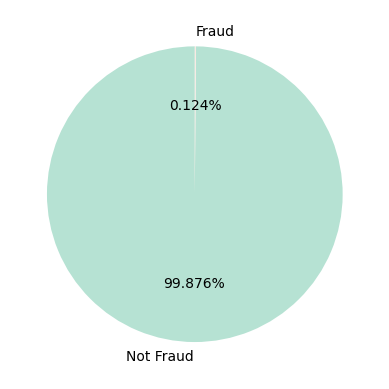

In [31]:
# Distribution of classes
print('\nCount:')
print(model_data['Is Fraud?'].value_counts())

print('\nDistribution:')
print(model_data['Is Fraud?'].value_counts() / model_data.shape[0])

# Visualize distribution with a pie chart
labels = ['Not Fraud', 'Fraud']
colors = ['#B6E2D3', '#FAE8E0']

plt.pie(model_data['Is Fraud?'].value_counts(), labels = labels, colors = colors, autopct='%.3f%%',startangle=90)
plt.show()

**Observation**
- Sample data class imbalance has 799,078 No and 922 Yes
- Majority of the transactions was not fraud. Only 0.125% of the transactions were fraud, therefore, we have an highly imbalanced class.


#### Divide independent variables into categorical and numerical features

In [32]:
# Identify categorical and numerical features
categorical_features = []
numerical_features = []
for i in model_data.columns:
    if model_data[i].dtype == 'object':
        categorical_features.append(i)  # Append to the list of categorical features
    else:
        numerical_features.append(i)    # Append to the list of numerical features

print(f"Categorical Features : {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features : ['Use Chip', 'Is Fraud?', 'MCC_Group']
Numerical Features: ['Month', 'Day', 'Amount', 'Hour']


Boxplot: Visualize the distribution and identify outliers for each variable

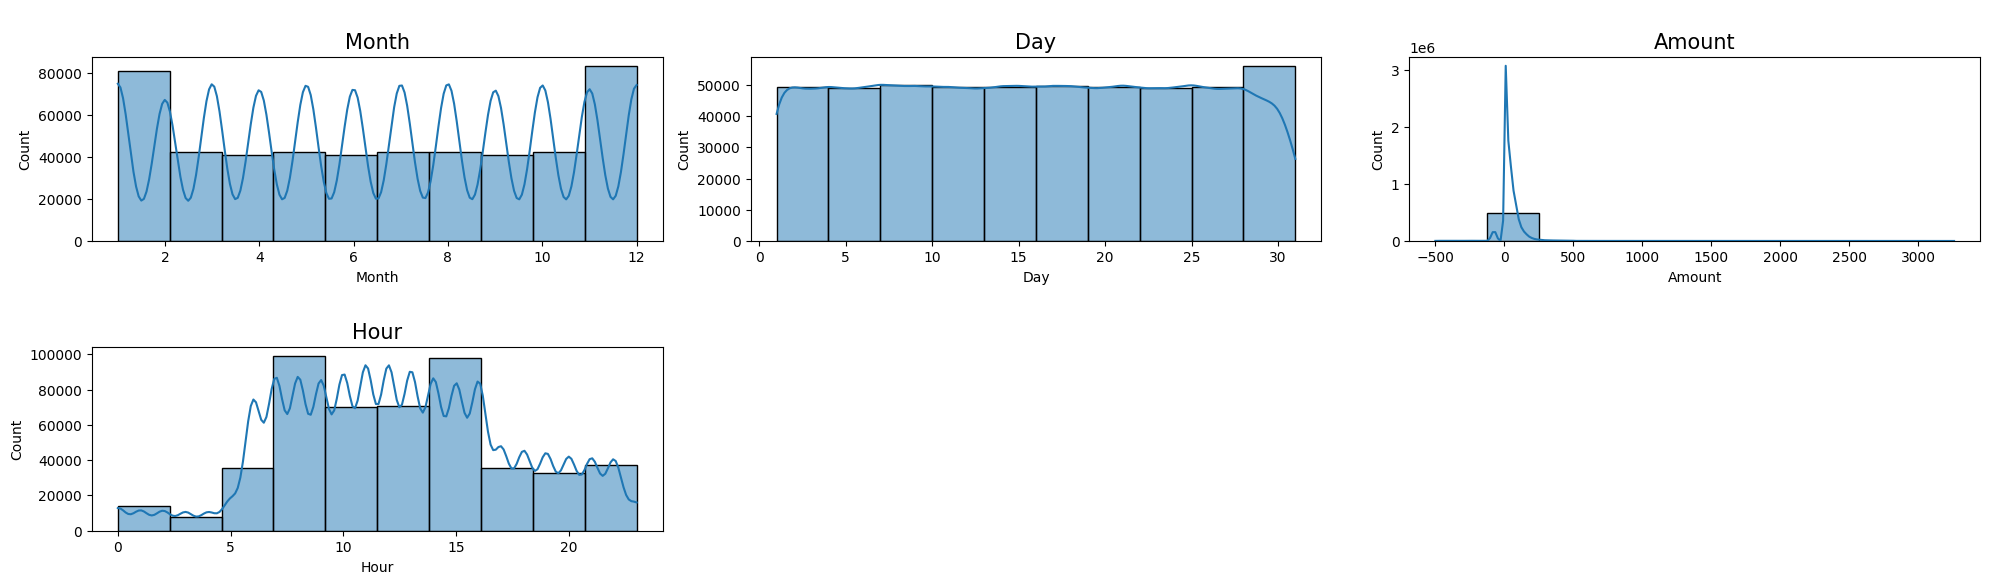

In [33]:
# Plot the histogram of numerical features
plt.figure(figsize = (20, 20))
plot_number = 1

bins_num= 10
for eachCol in numerical_features:
    if eachCol != "Is Fraud?":
        x = model_data[eachCol]
        y = model_data
        ax = plt.subplot(7, 3, plot_number)
        sns.histplot(x = x, data = y, ax = ax, bins = bins_num, kde=True)
        plt.title(f"\n{eachCol}", fontsize = 15)
        plot_number += 1

plt.tight_layout()
plt.show()

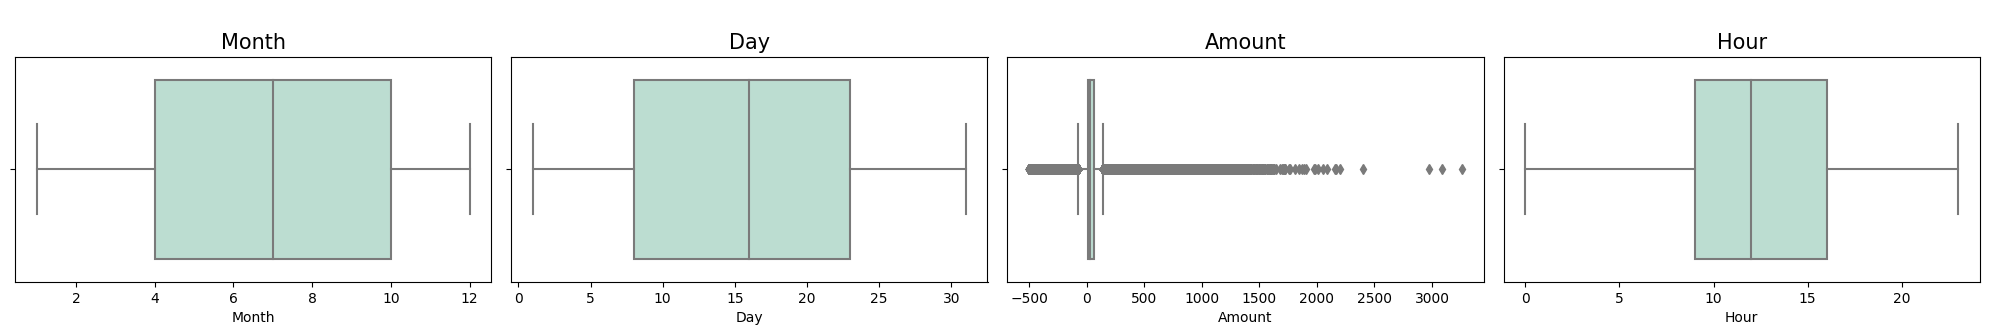

In [34]:
# Display the boxplot of numerical features
plt.figure(figsize = (20, 20))
plotnumber = 1

for feature in numerical_features:
    if feature != 'Is Fraud?':
        x = model_data[feature]
        ax = plt.subplot(7, 4, plotnumber)
        sns.boxplot(x = x, color=colors[0])
        plt.title(f"\n{model_data[feature].name}", fontsize = 15)
        plotnumber += 1
plt.tight_layout()
plt.show()

Stacked Bar Chart: Compare categories

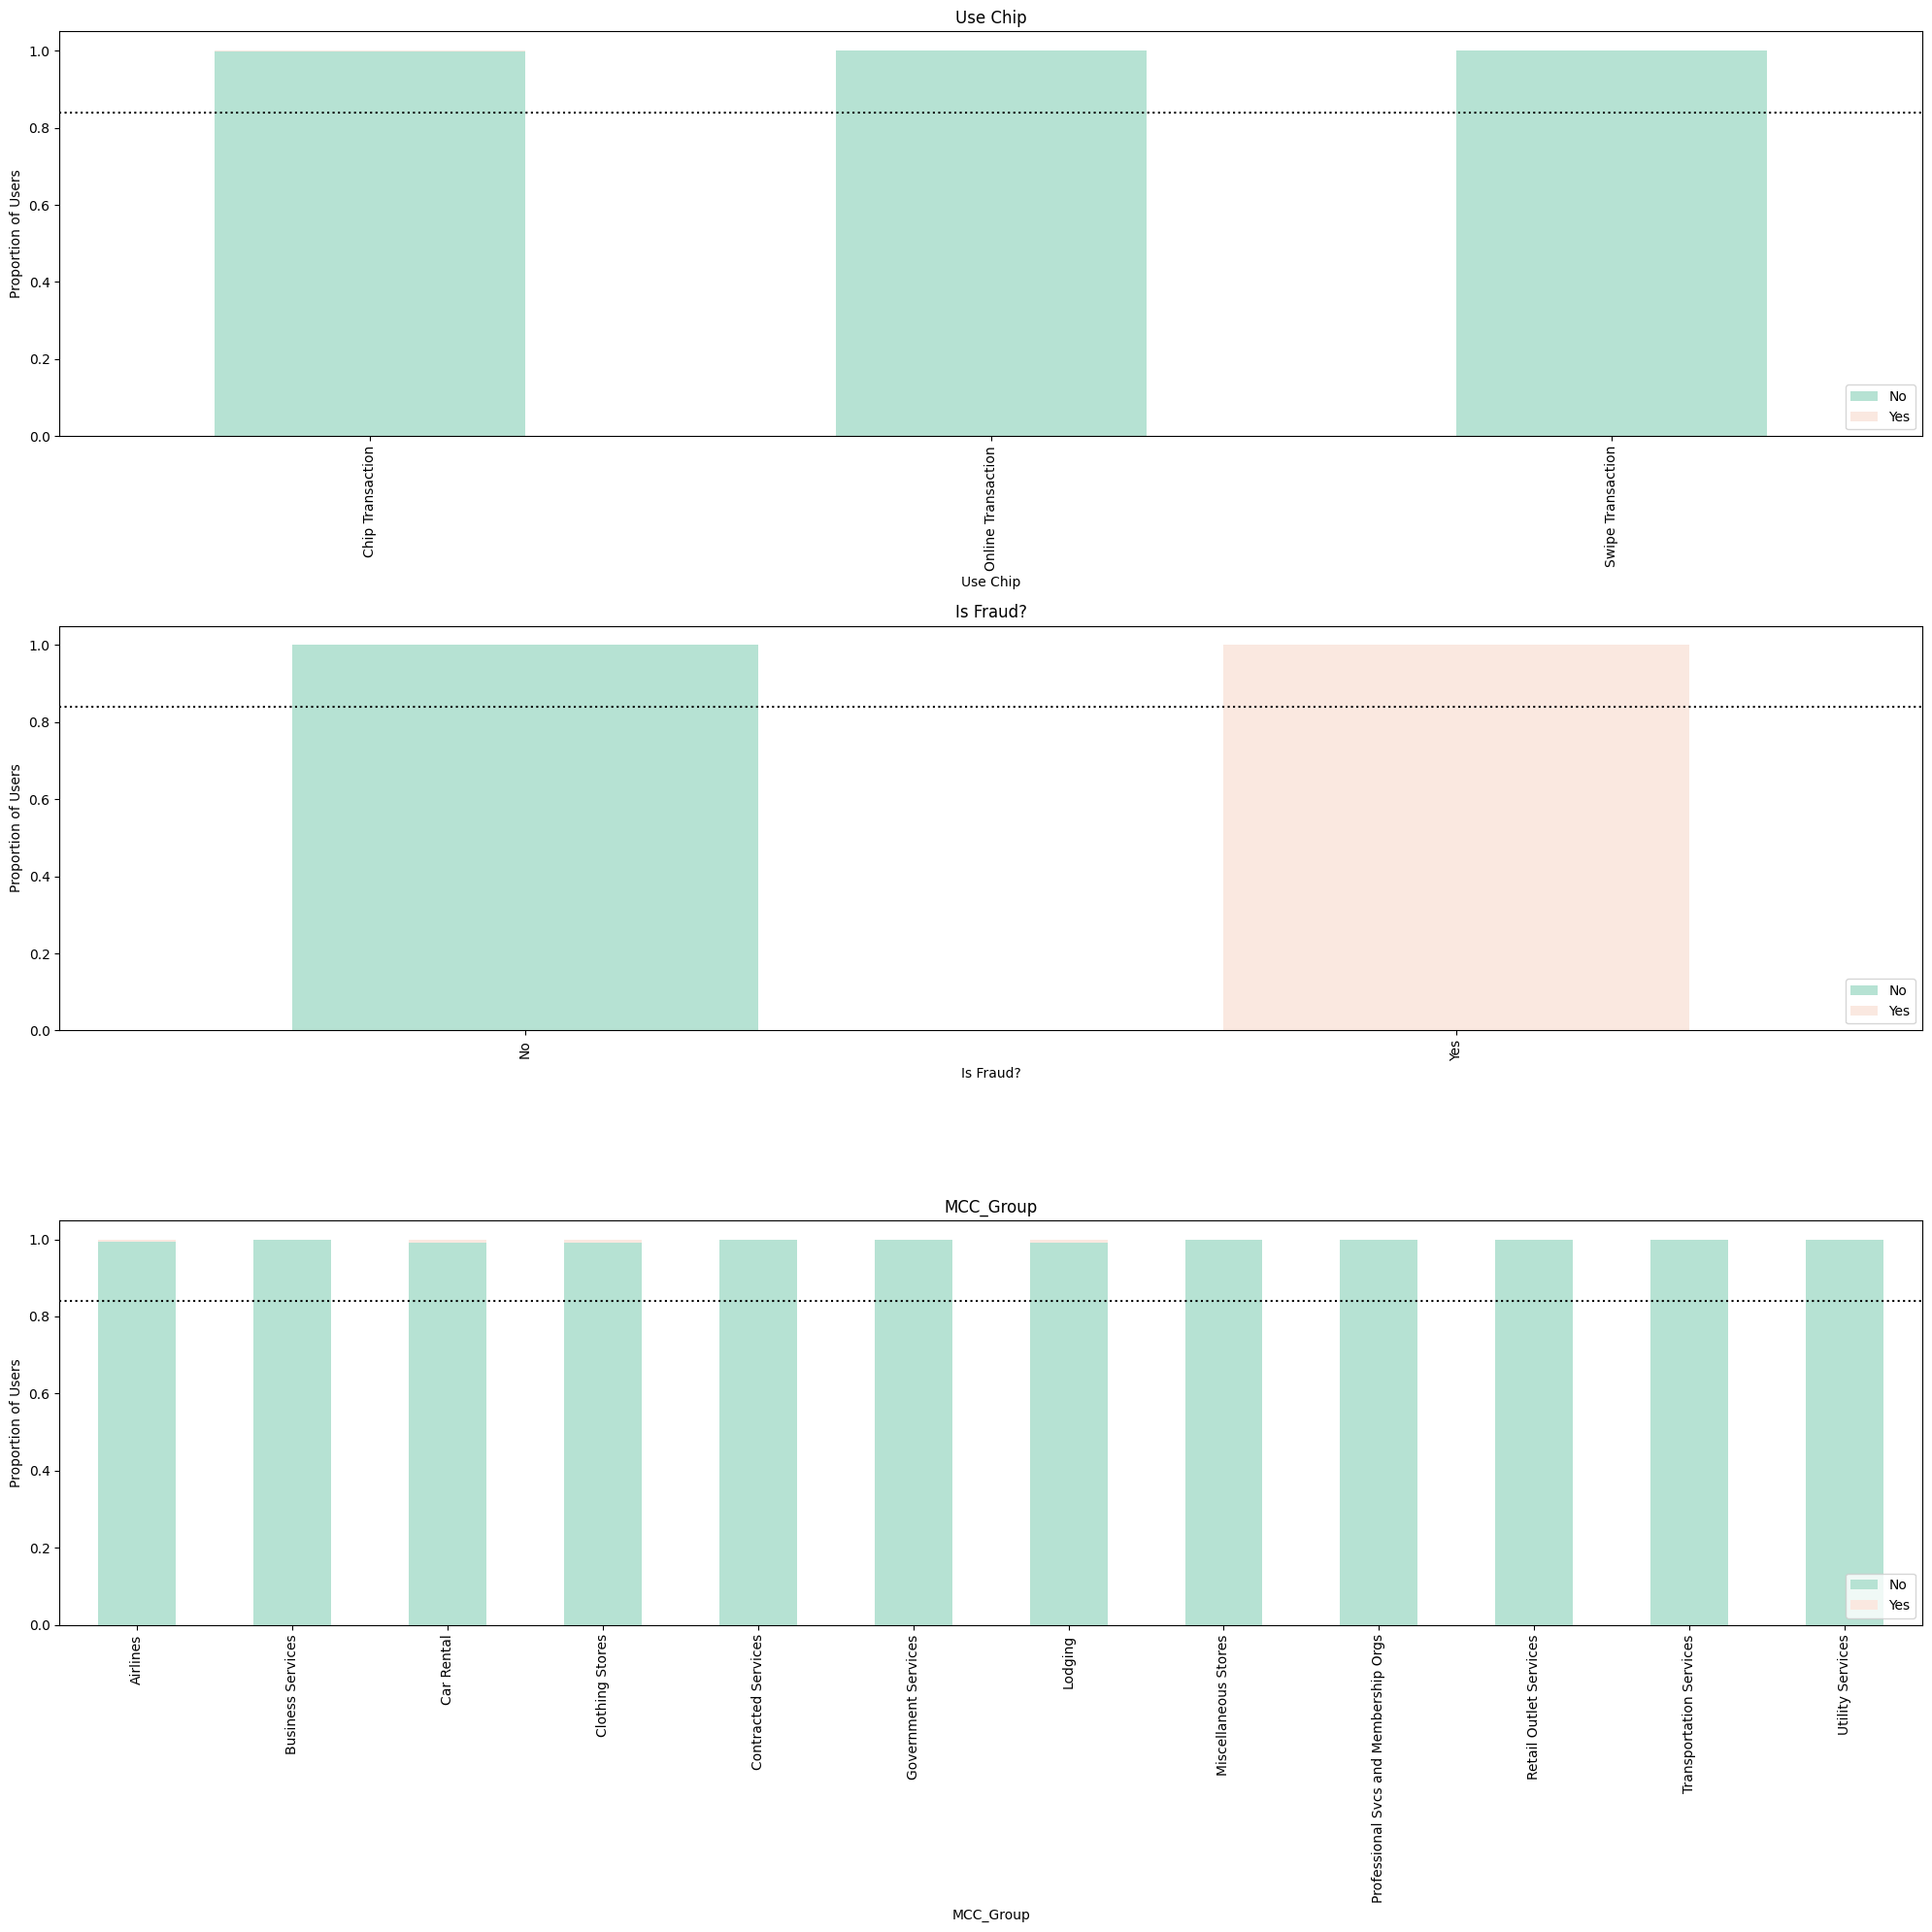

In [35]:
# Display stacked bar chart of categorical features
plt.figure(figsize = (20, 20))
plotnumber = 1
for feature in categorical_features:
    x = model_data[feature]
    ax = plt.subplot(3,1,plotnumber)   
    table=pd.crosstab(model_data[feature],model_data['Is Fraud?'])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',ax=ax, stacked=True, color = colors).legend(loc='lower right')
    plt.title(f'{feature}')
    plt.ylabel('Proportion of Users')
    plt.axhline(0.83934, color='black', ls='dotted')  # Baseline: Overall fraud rate
    plotnumber += 1

plt.tight_layout()
plt.show()

### Transform categorical to numerical

Target Variable <b>Is Fraud?</b> to numerical value

In [36]:
# Transform Is Fraud? to 1/0 value (Fraud: 1, Not Fraud: 0)
model_data["Is Fraud?"] = model_data["Is Fraud?"].replace({'No': 0, 'Yes': 1})
model_data.head(2)

,Month,Day,Amount,Use Chip,Is Fraud?,MCC_Group,Hour
11746636,9,25,51.05,Online Transaction,0,Transportation Services,14
10189954,4,16,20.00,Chip Transaction,0,Utility Services,21


In [37]:
getDataSummary(model_data)

,data_type,count_unique_values,count_null
Month,int64,12,0
Day,int64,31,0
Amount,float64,27650,0
Use Chip,object,3,0
Is Fraud?,int64,2,0
MCC_Group,object,12,0
Hour,int32,24,0


One Hot Encoding for Use Chip

In [38]:
model_data = pd.get_dummies(model_data, columns=['Use Chip'], drop_first=True)

print(model_data.info())
model_data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 11746636 to 21768359
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Month                        500000 non-null  int64  
 1   Day                          500000 non-null  int64  
 2   Amount                       500000 non-null  float64
 3   Is Fraud?                    500000 non-null  int64  
 4   MCC_Group                    500000 non-null  object 
 5   Hour                         500000 non-null  int32  
 6   Use Chip_Online Transaction  500000 non-null  uint8  
 7   Use Chip_Swipe Transaction   500000 non-null  uint8  
dtypes: float64(1), int32(1), int64(3), object(1), uint8(2)
memory usage: 25.7+ MB
None


,Month,Day,Amount,Is Fraud?,MCC_Group,Hour,Use Chip_Online Transaction,Use Chip_Swipe Transaction
11746636,9,25,51.05,0,Transportation Services,14,1,0
10189954,4,16,20.00,0,Utility Services,21,0,0
19600879,11,25,1759.43,0,Professional Svcs and Membership Orgs,12,0,0


In [39]:
# One-hot encoding for MCC Groups
model_data = pd.get_dummies(model_data, columns=['MCC_Group'], drop_first=False)

print(model_data.info())
model_data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 11746636 to 21768359
Data columns (total 19 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Month                                            500000 non-null  int64  
 1   Day                                              500000 non-null  int64  
 2   Amount                                           500000 non-null  float64
 3   Is Fraud?                                        500000 non-null  int64  
 4   Hour                                             500000 non-null  int32  
 5   Use Chip_Online Transaction                      500000 non-null  uint8  
 6   Use Chip_Swipe Transaction                       500000 non-null  uint8  
 7   MCC_Group_Airlines                               500000 non-null  uint8  
 8   MCC_Group_Business Services                      500000 non-null  uint8  
 9   MCC_Gr

,Month,Day,Amount,Is Fraud?,Hour,Use Chip_Online Transaction,Use Chip_Swipe Transaction,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,MCC_Group_Government Services,MCC_Group_Lodging,MCC_Group_Miscellaneous Stores,MCC_Group_Professional Svcs and Membership Orgs,MCC_Group_Retail Outlet Services,MCC_Group_Transportation Services,MCC_Group_Utility Services
11746636,9,25,51.05,0,14,1,0,0,0,0,0,0,0,0,0,0,0,1,0
10189954,4,16,20.00,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,1
19600879,11,25,1759.43,0,12,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [40]:
# One-hot encoding for Month
model_data = pd.get_dummies(model_data, columns=['Month'], drop_first=False)

print(model_data.info())
model_data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 11746636 to 21768359
Data columns (total 30 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Day                                              500000 non-null  int64  
 1   Amount                                           500000 non-null  float64
 2   Is Fraud?                                        500000 non-null  int64  
 3   Hour                                             500000 non-null  int32  
 4   Use Chip_Online Transaction                      500000 non-null  uint8  
 5   Use Chip_Swipe Transaction                       500000 non-null  uint8  
 6   MCC_Group_Airlines                               500000 non-null  uint8  
 7   MCC_Group_Business Services                      500000 non-null  uint8  
 8   MCC_Group_Car Rental                             500000 non-null  uint8  
 9   MCC_Gr

,Day,Amount,Is Fraud?,Hour,Use Chip_Online Transaction,Use Chip_Swipe Transaction,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
11746636,25,51.05,0,14,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10189954,16,20.00,0,21,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19600879,25,1759.43,0,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


BaseN Encoding for 'Merchant City' - Remove for now since this feature doesnt seem important
<!-- https://medium.com/analytics-vidhya/types-of-categorical-data-encoding-schemes-a5bbeb4ba02b -->

In [41]:
# model_data.drop(columns=['Merchant City'], axis=1, inplace=True)

# import category_encoders as ce

# # create an object of the BaseNEncoder
# ce_baseN4 = ce.BaseNEncoder(cols=['Merchant City'],base=4)

# # fit and transform and you will get the encoded data
# model_data = ce_baseN4.fit_transform(model_data)

# print(model_data.info())
# model_data.head(10)


In [42]:
getDataSummary(model_data)

,data_type,count_unique_values,count_null
Day,int64,31,0
Amount,float64,27650,0
Is Fraud?,int64,2,0
Hour,int32,24,0
Use Chip_Online Transaction,uint8,2,0
Use Chip_Swipe Transaction,uint8,2,0
MCC_Group_Airlines,uint8,2,0
MCC_Group_Business Services,uint8,2,0
MCC_Group_Car Rental,uint8,2,0
MCC_Group_Clothing Stores,uint8,2,0


#### Correlation Heatmap

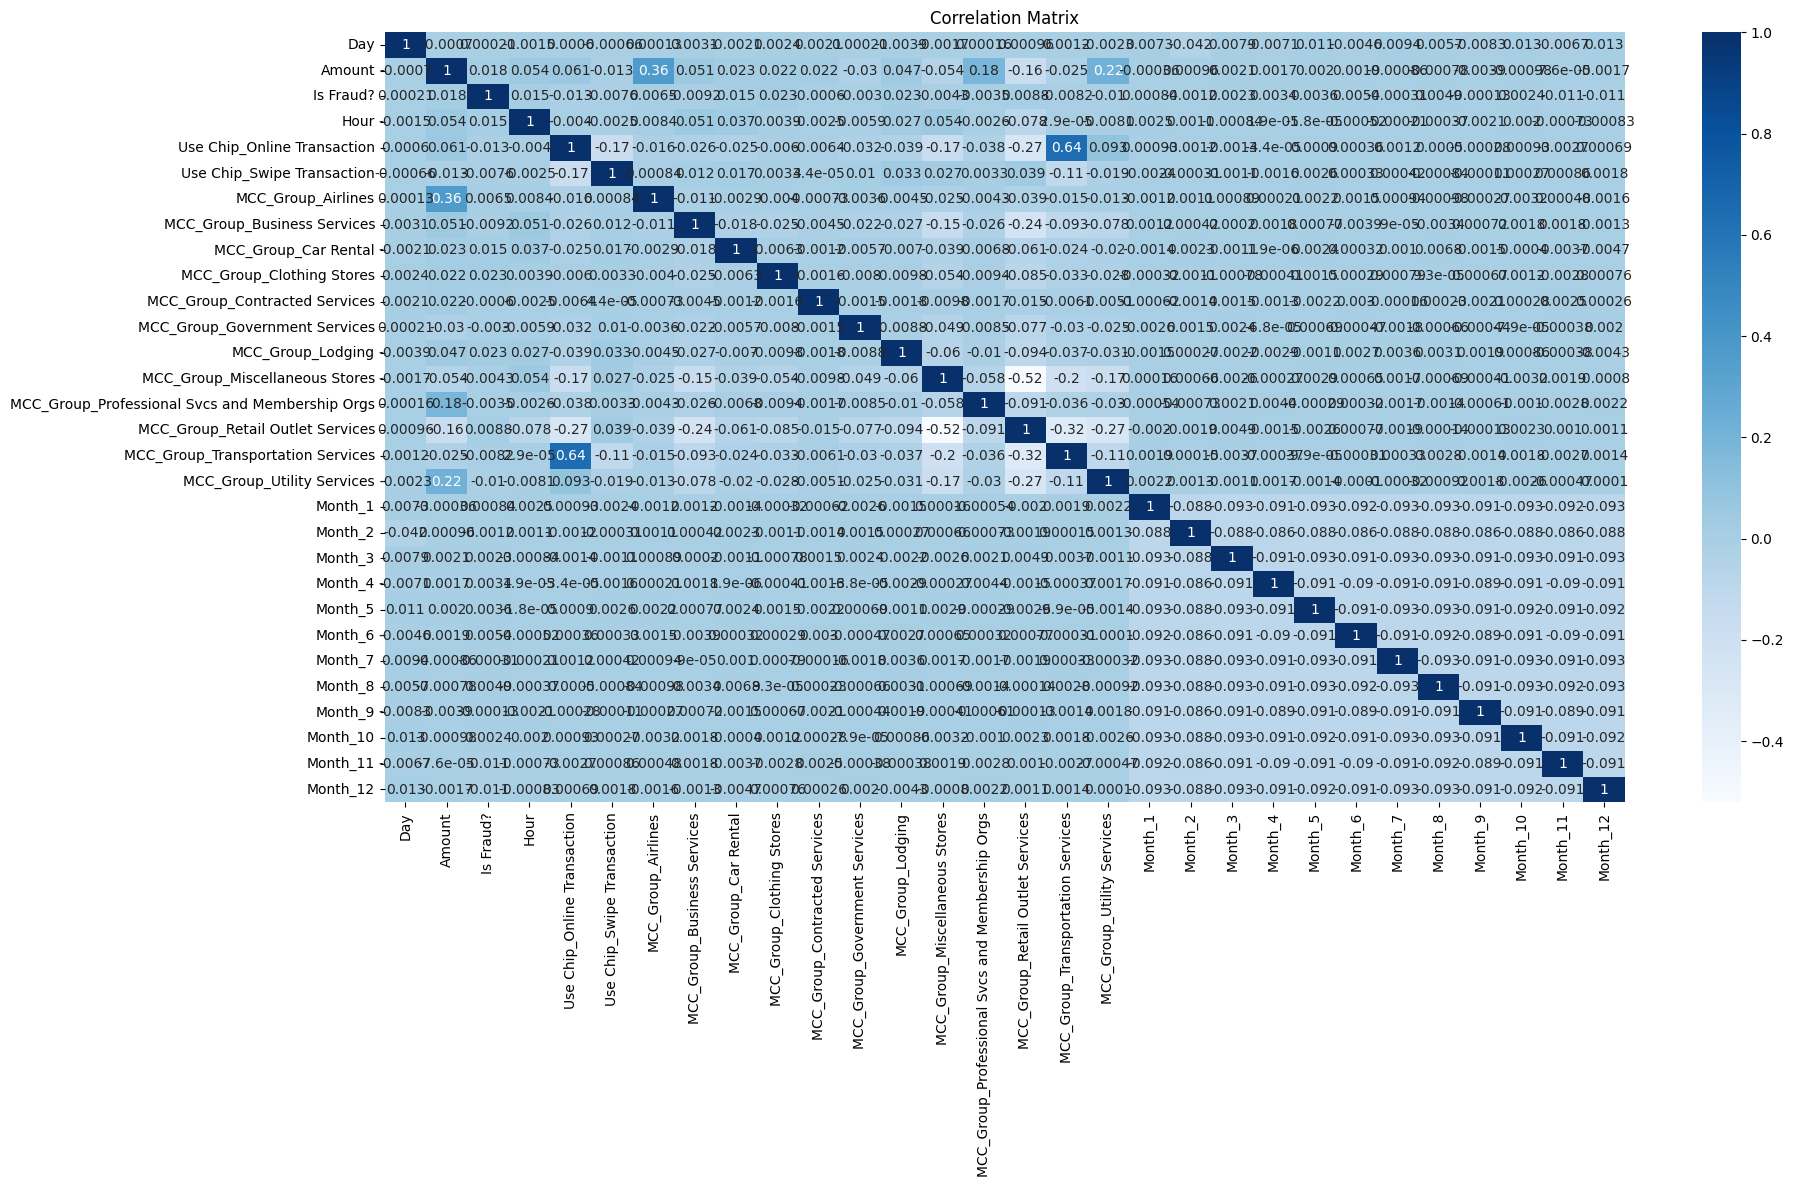

In [43]:
# Correlation Heat Map: Pair-wise correlation
plt.figure(figsize=(20,10))
sns.heatmap(model_data.corr(), annot=True, cmap='Blues')  #coolwarm
plt.title('Correlation Matrix')
plt.show()

<b>Observation: </b>

Weak multicolinearity between all the variables

<br>Reference: https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8

----------
## <center> Divide to Dependent and Independent Variables
----------

In [44]:
# Assign the Y and X features
y_values = model_data.loc[:, model_data.columns == 'Is Fraud?']
X_values = model_data.loc[:, model_data.columns != 'Is Fraud?']

print('Dependent Variable:')
print(y_values.columns)

print('\nIndependent Variables:',len(X_values.columns))
print(X_values.columns)

Dependent Variable:
Index(['Is Fraud?'], dtype='object')

Independent Variables: 29
Index(['Day', 'Amount', 'Hour', 'Use Chip_Online Transaction',
       'Use Chip_Swipe Transaction', 'MCC_Group_Airlines',
       'MCC_Group_Business Services', 'MCC_Group_Car Rental',
       'MCC_Group_Clothing Stores', 'MCC_Group_Contracted Services',
       'MCC_Group_Government Services', 'MCC_Group_Lodging',
       'MCC_Group_Miscellaneous Stores',
       'MCC_Group_Professional Svcs and Membership Orgs',
       'MCC_Group_Retail Outlet Services', 'MCC_Group_Transportation Services',
       'MCC_Group_Utility Services', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12'],
      dtype='object')


----------
## <center> Split Data to TRAIN and TEST
----------

In [45]:
# Split the data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_values,y_values,test_size=0.3,random_state=1234)

print('X Train:',X_train.shape)
print('Y Train:',y_train.shape)
print('X Test:',X_test.shape)
print('Y Test:',y_test.shape)
X_train.head()

X Train: (350000, 29)
Y Train: (350000, 1)
X Test: (150000, 29)
Y Test: (150000, 1)


,Day,Amount,Hour,Use Chip_Online Transaction,Use Chip_Swipe Transaction,MCC_Group_Airlines,MCC_Group_Business Services,MCC_Group_Car Rental,MCC_Group_Clothing Stores,MCC_Group_Contracted Services,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
3633454,27,17.87,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11931615,17,1.83,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20527665,12,25.10,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7161189,2,10.86,12,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
23539812,4,69.07,6,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


----------
## <center> Feature Engineering
----------

### Scaling

### Oversampling Imbalance Class

In [46]:
from imblearn.over_sampling import SMOTE
# oversample = SMOTE(sampling_strategy = {0: 1000, 1: 500},random_state=1234)
oversample = SMOTE(random_state=1234)

# Perform oversampling using SMOTE
x_oversample_dtree,y_oversample_dtree = oversample.fit_resample(X_train, y_train)

# Class distribution after performing SMOTE
print('\nAfter Oversampling:')
print('No. of Observations:',len(y_oversample_dtree))
print(y_oversample_dtree['Is Fraud?'].value_counts() / len(y_oversample_dtree))


After Oversampling:
No. of Observations: 699110
0    0.5
1    0.5
Name: Is Fraud?, dtype: float64


----------
## <center> Feature Selection
----------

### K-Fold Cross Validation
- Use K-Fold Cross Validation on the training set to identify the optimal depth of the tree. The minimum leaf size is set to 500.
- The decision tree is evaluated on imbalanced dataset with SMOTE oversampling
- This step uses RepeatedStratifiedKFold which repeats the cross-validation procedure n times for a more accurate estimate of model performance

In [47]:
# # Fitting trees on the training data using cross-validation
# def CrossValidation_DecisionTree(X, y, tree_depths, scoring):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1234)
#     scores_list = []
#     scores_std = []
#     scores_mean = []
#     accuracy_scores = []
#     for depth in tree_depths:
#         tree_model = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=500, max_depth=depth)
#         steps = [('over', SMOTE(random_state = 1234)), ('model', tree_model)]
#         pipeline = Pipeline(steps=steps)
#         cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)       
#         scores_list.append(cv_scores)
#         scores_mean.append(cv_scores.mean())
#         scores_std.append(cv_scores.std())
#         accuracy_scores.append(tree_model.fit(X, y).score(X, y))
#     scores_mean = np.array(scores_mean)
#     scores_std = np.array(scores_std)
#     accuracy_scores = np.array(accuracy_scores)
#     return scores_mean, scores_std, accuracy_scores
  
# # Plotting cross-validation results
# def CrossValidationPlot_DecisionTree(depths, scores_mean, scores_std, accuracy_scores, title):
#     fig, ax = plt.subplots(1,1, figsize=(15,5))
#     ax.plot(depths, scores_mean, '-o', label='average cross-validation accuracy (test accuracy)', alpha=0.9)
#     ax.fill_between(depths, scores_mean-2*scores_std, scores_mean+2*scores_std, alpha=0.2)
#     ax.plot(depths, accuracy_scores, '-*', label='training accuracy', alpha=0.9)
#     ax.set_title(title + ' per Tree Depth', fontsize=16)
#     ax.set_xlabel('Tree Depth', fontsize=13)
#     ax.set_ylabel(title, fontsize=13)
#     ax.set_ylim(0,1)
#     ax.set_xticks(depths)
#     ax.legend()

# # Depths to be run
# tree_depths = range(1,15)

# # Cross-validation Results: mean, stdev, accuracy
# scores_mean_accuracy, scores_std_accuracy, accuracy_scores = CrossValidation_DecisionTree(X_train, y_train, tree_depths, scoring='accuracy')
# scores_mean_recall, scores_std_recall, recall_scores = CrossValidation_DecisionTree(X_train, y_train, tree_depths, scoring='recall')
    
# # Plot results
# CrossValidationPlot_DecisionTree(tree_depths, scores_mean_accuracy, scores_std_accuracy, accuracy_scores, 'Accuracy Score')
# CrossValidationPlot_DecisionTree(tree_depths, scores_mean_recall, scores_std_recall, recall_scores, 'Recall Score')

**Observation:**
- Based on the graphs, it seems that depth of 7 or 8 has the good combination of accuracy and recall.

In [48]:
# # Fitting trees on the training data using cross-validation
# def CrossValidation_DecisionTree(X, y, samples_leaf_sizes, scoring):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1234)
#     scores_list = []
#     scores_std = []
#     scores_mean = []
#     accuracy_scores = []
#     for leaf_size in samples_leaf_sizes:
#         tree_model = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=leaf_size, max_depth=7)
#         steps = [('over', SMOTE(random_state = 1234)), ('model', tree_model)]
#         pipeline = Pipeline(steps=steps)
#         cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)       
#         scores_list.append(cv_scores)
#         scores_mean.append(cv_scores.mean())
#         scores_std.append(cv_scores.std())
#         accuracy_scores.append(tree_model.fit(X, y).score(X, y))
#     scores_mean = np.array(scores_mean)
#     scores_std = np.array(scores_std)
#     accuracy_scores = np.array(accuracy_scores)
#     return scores_mean, scores_std, accuracy_scores
  
# # Plotting cross-validation results
# def CrossValidationPlot_DecisionTree(samples_leaf_sizes, scores_mean, scores_std, accuracy_scores, title):
#     fig, ax = plt.subplots(1,1, figsize=(15,5))
#     ax.plot(samples_leaf_sizes, scores_mean, '-o', label='average cross-validation accuracy (test accuracy)', alpha=0.9)
#     ax.fill_between(samples_leaf_sizes, scores_mean-2*scores_std, scores_mean+2*scores_std, alpha=0.2)
#     ax.plot(samples_leaf_sizes, accuracy_scores, '-*', label='training accuracy', alpha=0.9)
#     ax.set_title(title + ' per Min Leaf Size', fontsize=16)
#     ax.set_xlabel('Min Leaf Size', fontsize=13)
#     ax.set_ylabel(title, fontsize=13)
#     ax.set_ylim(0,1)
#     ax.set_xticks(samples_leaf_sizes)
#     ax.legend()

# # Depths to be run
# # tree_depths = range(1,20)
# samples_leaf_sizes = [100,500,1000,2000,3000,4000,5000,10000]

# # Cross-validation Results: mean, stdev, accuracy
# scores_mean_accuracy, scores_std_accuracy, accuracy_scores = CrossValidation_DecisionTree(X_train, y_train, samples_leaf_sizes, scoring='accuracy')
# scores_mean_recall, scores_std_recall, recall_scores = CrossValidation_DecisionTree(X_train, y_train, samples_leaf_sizes, scoring='recall')
    
# # Plot results
# CrossValidationPlot_DecisionTree(samples_leaf_sizes, scores_mean_accuracy, scores_std_accuracy, accuracy_scores, 'Accuracy Score')
# CrossValidationPlot_DecisionTree(samples_leaf_sizes, scores_mean_recall, scores_std_recall, recall_scores, 'Recall Score')

----------
## Model Training
----------

In [49]:
# Fit decision tree model
# model_dtree = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=500, max_depth=8)
model_dtree = DecisionTreeClassifier(random_state = 1234, min_samples_leaf=500, max_depth=7)
model_dtree.fit(x_oversample_dtree, y_oversample_dtree)

# Predict the values of y in both the training and test datasets
# predict() is used to predict the class labels (1/0)
y_pred_train_dtree = model_dtree.predict(x_oversample_dtree)
y_pred_test_dtree = model_dtree.predict(X_test)

# predict_proba() is used to output probability estimates
y_pred_train_prob_dtree = model_dtree.predict_proba(x_oversample_dtree)
y_pred_test_prob_dtree = model_dtree.predict_proba(X_test)

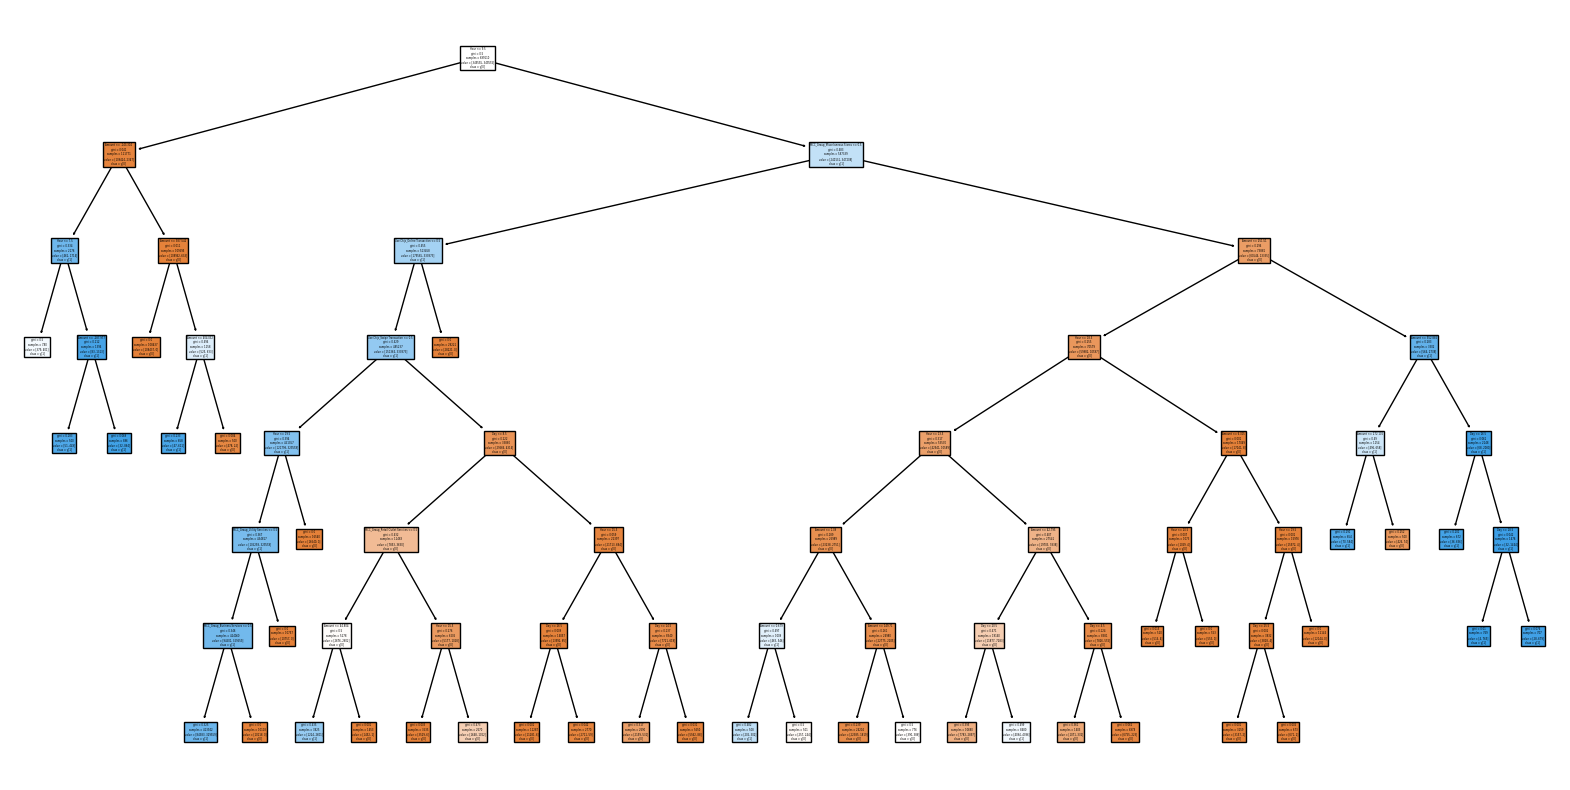

In [50]:
# Plot decision tree
fig = plt.figure(figsize = (20, 10))
tree.plot_tree(model_dtree, feature_names = list(x_oversample_dtree.columns), class_names = True, filled = True)
plt.show()

In [51]:
# Summary of Decision Tree Features 
dtree_summary = pd.DataFrame()
dtree_summary['Feature'] = x_oversample_dtree.columns
dtree_summary['Feature Importance'] = model_dtree.feature_importances_
dtree_summary = dtree_summary[dtree_summary['Feature Importance']>0]
dtree_summary

,Feature,Feature Importance
0,Day,0.010348
1,Amount,0.050896
2,Hour,0.417001
3,Use Chip_Online Transaction,0.128587
4,Use Chip_Swipe Transaction,0.116628
6,MCC_Group_Business Services,0.063755
12,MCC_Group_Miscellaneous Stores,0.145146
14,MCC_Group_Retail Outlet Services,0.003112
16,MCC_Group_Utility Services,0.064527


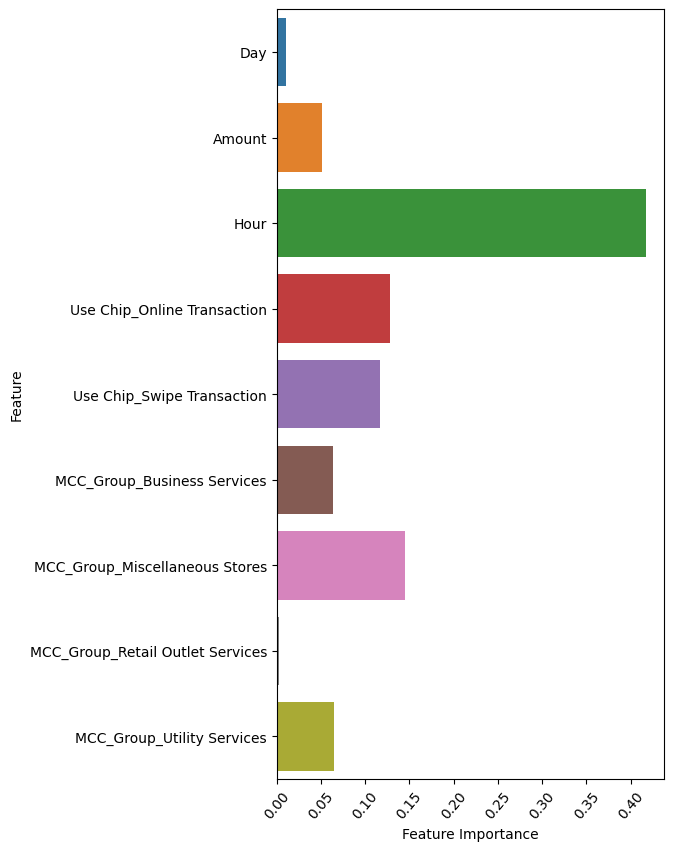

In [52]:
# Plot feature importance
fig = plt.figure(figsize = (5, 10))
# sns.barplot(x=model_dtree.feature_importances_, y=x_oversample_dtree.columns)
sns.barplot(x=dtree_summary['Feature Importance'], y=dtree_summary['Feature'])
plt.xticks(rotation = 50)
plt.show()

----------
## <center> Model Evaluation
----------

In [53]:
# Create a summary of model scores
model_score_list = ['classification accuracy', 
                    'precision', 
                    'recall', 
                    'f1 score',  
                    'ROC AUC',]

model_score = pd.DataFrame(pd.Series(model_score_list))
model_score.set_index(0, inplace=True)
# model_score

In [57]:
isTrainData = True

for sample_data in list([[y_oversample_dtree, y_pred_train_dtree], [y_test, y_pred_test_dtree]]):
    y_dtree = sample_data[0]
    y_pred = sample_data[1]

    rowIndex = model_score.index[0]
    model_score.loc[rowIndex, '1 - Yes'] = np.nan
    model_score.loc[rowIndex, '0 - No'] = np.nan
    model_score.loc[rowIndex, 'weighted ave'] =accuracy_score(y_dtree, y_pred).round(3)
    model_score

    rowIndex = model_score.index[1] 
    model_score.loc[rowIndex, '1 - Yes'] = precision_score(y_dtree,y_pred, pos_label=1).round(3)
    model_score.loc[rowIndex, '0 - No'] = precision_score(y_dtree,y_pred, pos_label=0).round(3)
    model_score.loc[rowIndex, 'weighted ave'] = precision_score(y_dtree,y_pred, average='weighted').round(3)

    rowIndex = model_score.index[2]
    model_score.loc[rowIndex, '1 - Yes'] = recall_score(y_dtree,y_pred, pos_label=1).round(3)
    model_score.loc[rowIndex, '0 - No'] = recall_score(y_dtree,y_pred, pos_label=0).round(3)
    model_score.loc[rowIndex, 'weighted ave'] = recall_score(y_dtree,y_pred, average='weighted').round(3)

    rowIndex = model_score.index[3]
    model_score.loc[rowIndex, '1 - Yes'] = f1_score(y_dtree,y_pred, pos_label=1).round(3)
    model_score.loc[rowIndex, '0 - No'] = f1_score(y_dtree,y_pred, pos_label=0).round(3)
    model_score.loc[rowIndex, 'weighted ave'] = f1_score(y_dtree,y_pred, average='weighted').round(3)

    if isTrainData:
        model_score.index.name = 'TRAIN Model Score'
    else:
        model_score.index.name = 'TEST Model Score'

    display(model_score)
    isTrainData =  False

,1 - Yes,0 - No,weighted ave
TRAIN Model Score,,,
classification accuracy,NaN,NaN,0.859
precision,0.791,0.971,0.881
recall,0.978,0.741,0.859
f1 score,0.874,0.841,0.857
ROC AUC,NaN,NaN,NaN


,1 - Yes,0 - No,weighted ave
TEST Model Score,,,
classification accuracy,NaN,NaN,0.741
precision,0.004,1.000,0.999
recall,0.799,0.741,0.741
f1 score,0.007,0.851,0.850
ROC AUC,NaN,NaN,NaN


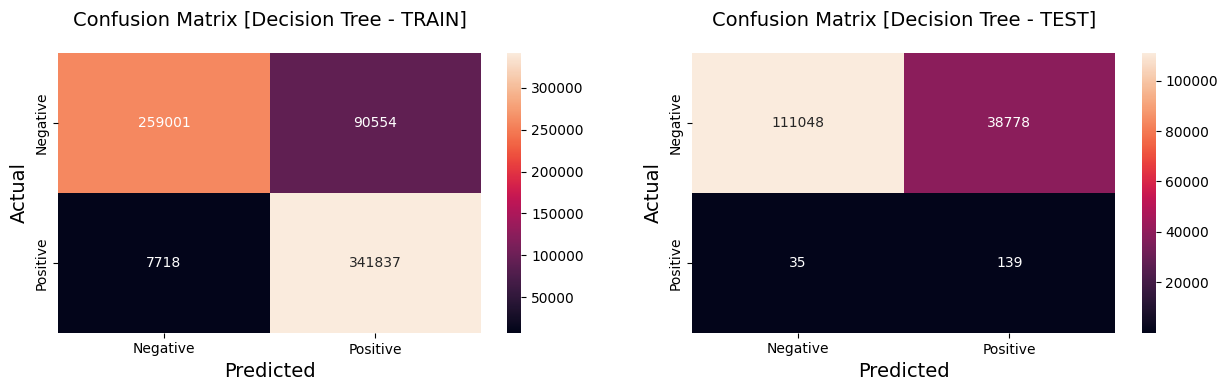

In [55]:
# Order of the input parameters is important: 
# 1st parameter - actual values
# 2nd parameter - predicted values
conf_matrix_train = confusion_matrix(y_oversample_dtree, y_pred_train_dtree)
conf_matrix_test = confusion_matrix(y_test, y_pred_test_dtree)


# Plot Confusion Matrix TRAIN

plt.figure(figsize=(15,8))

ax = plt.subplot(2, 2, 1)
ax = sns.heatmap(conf_matrix_train, annot=True, fmt='d')
# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
# set plot title
ax.set_title(f"Confusion Matrix [Decision Tree - TRAIN]", fontsize=14, pad=20)


# Plot Confusion Matrix TEST
ax = plt.subplot(2, 2, 2)
ax = sns.heatmap(conf_matrix_test, annot=True, fmt='d')
# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
# set plot title
ax.set_title(f"Confusion Matrix [Decision Tree - TEST]", fontsize=14, pad=20)
plt.show()